# Corso di Quantum Computing - Giorno 5: <br> Transpiler

Codice complementare alla sezione "*Come usare il transpiler di Qiskit*" del PowerPoint.

Corso per Epigenesys s.r.l. <br>
Docenti: Sara Galatro e Lorenzo Gasparini <br>
Supervisore: Prof. Marco Pedicini

## Translation Stage

Prendiamo come target `FakeVigoV2` e vediamone le caratteristiche:

In [5]:
from qiskit.providers.fake_provider import FakeVigoV2
backend = FakeVigoV2()

print(backend.target)
#print(backend.operation_names)

Target
Number of qubits: 5
Instructions:
	id
		(0,):
			Duration: 3.5555555555555554e-08 sec.
			Error Rate: 0.0004135213478316029
		(1,):
			Duration: 3.5555555555555554e-08 sec.
			Error Rate: 0.0005020255558466025
		(2,):
			Duration: 3.5555555555555554e-08 sec.
			Error Rate: 0.00040033040197886486
		(3,):
			Duration: 3.5555555555555554e-08 sec.
			Error Rate: 0.0006149355812506126
		(4,):
			Duration: 3.5555555555555554e-08 sec.
			Error Rate: 0.0006307673923554075
	rz
		(0,):
			Duration: 0.0 sec.
			Error Rate: 0
		(1,):
			Duration: 0.0 sec.
			Error Rate: 0
		(2,):
			Duration: 0.0 sec.
			Error Rate: 0
		(3,):
			Duration: 0.0 sec.
			Error Rate: 0
		(4,):
			Duration: 0.0 sec.
			Error Rate: 0
	sx
		(0,):
			Duration: 3.5555555555555554e-08 sec.
			Error Rate: 0.0004135213478316029
		(1,):
			Duration: 3.5555555555555554e-08 sec.
			Error Rate: 0.0005020255558466025
		(2,):
			Duration: 3.5555555555555554e-08 sec.
			Error Rate: 0.00040033040197886486
		(3,):
			Duration: 3

Prendiamo ad esempio il seguente circuito:

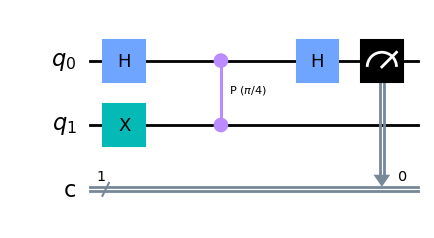

In [6]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.providers.fake_provider import FakeVigoV2

backend = FakeVigoV2()

qc = QuantumCircuit(2, 1)

qc.h(0)
qc.x(1)
qc.cp(np.pi/4, 0, 1)
qc.h(0)
qc.measure(0,0)
qc.draw(output='mpl')

I gate $\mathbf{H,CP}$ non sono gate base per la nostra macchina, quindi dobbiamo tradurli:

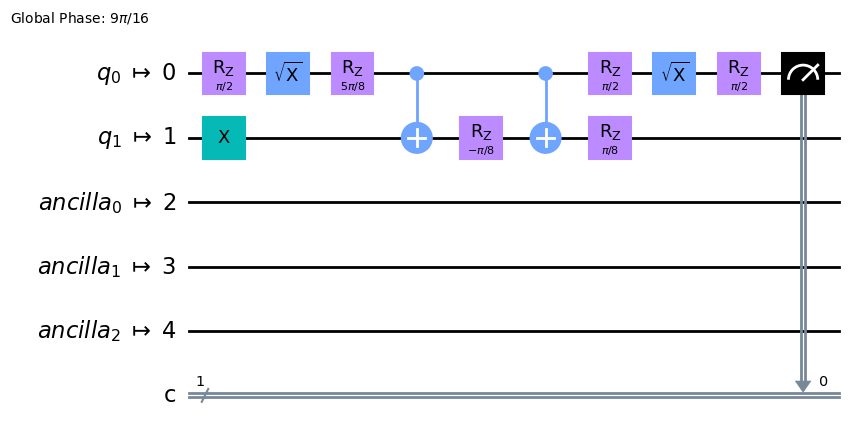

In [7]:
from qiskit import transpile
from qiskit import QuantumCircuit
from qiskit.providers.fake_provider import FakeVigoV2

backend = FakeVigoV2()

qc = QuantumCircuit(2, 1)

qc.h(0)
qc.x(1)
qc.cp(np.pi/4, 0, 1)
qc.h(0)
qc.measure(0,0)

qc_basis = transpile(qc, backend)
qc_basis.draw(output='mpl')

La profondità è aumentata:

In [8]:
print('Original depth:', qc.depth(), 
      'Decomposed Depth:', qc_basis.depth())

Original depth: 4 Decomposed Depth: 10


Riportiamo il codice per vedere la decomposizione del Toffoli gate:

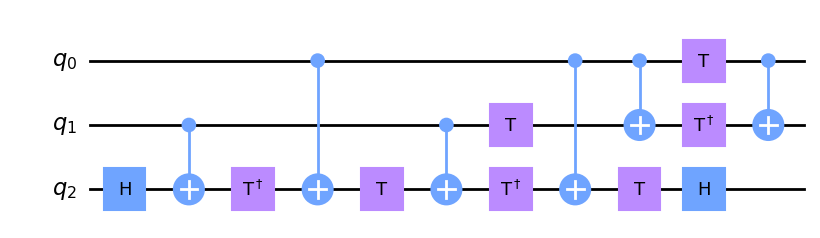

In [9]:
from qiskit.circuit import QuantumCircuit

ccx_circ = QuantumCircuit(3)
ccx_circ.ccx(0, 1, 2)
ccx_circ.decompose().draw(output='mpl')

## Layout Stage

Definiamo il nostro circuito:

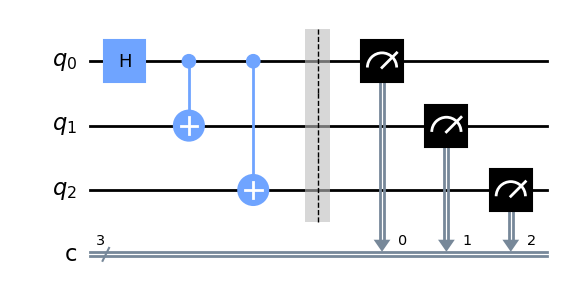

In [10]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_circuit_layout
from qiskit.providers.fake_provider import FakeVigoV2

backend = FakeVigoV2()

ghz = QuantumCircuit(3, 3)
ghz.h(0)
ghz.cx(0,range(1,3))
ghz.barrier()
ghz.measure(range(3), range(3))
ghz.draw(output='mpl')

e vediamo che layout viene scelto in base al livello di ottimizzazione.

**Livello 0**

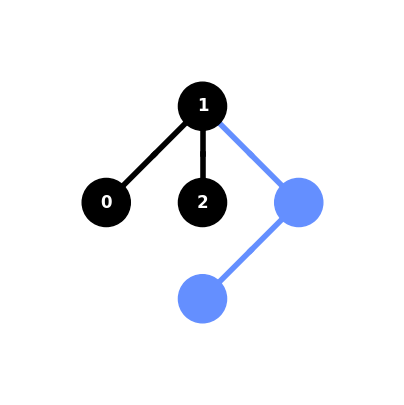

In [11]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_circuit_layout
from qiskit.providers.fake_provider import FakeVigoV2

backend = FakeVigoV2()

ghz = QuantumCircuit(3, 3)
ghz.h(0)
ghz.cx(0,range(1,3))
ghz.barrier()
ghz.measure(range(3), range(3))

new_circ_lv0 = transpile(ghz, backend=backend, optimization_level=0)
plot_circuit_layout(new_circ_lv0, backend)

**Livello 3**

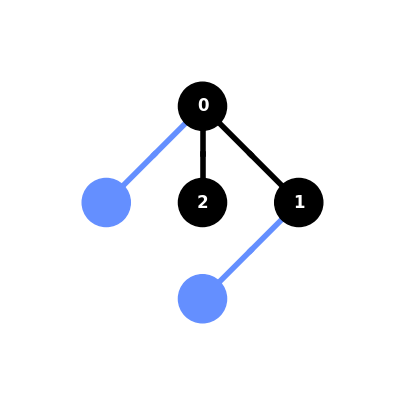

In [12]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_circuit_layout
from qiskit.providers.fake_provider import FakeVigoV2

backend = FakeVigoV2()

ghz = QuantumCircuit(3, 3)
ghz.h(0)
ghz.cx(0,range(1,3))
ghz.barrier()
ghz.measure(range(3), range(3))

new_circ_lv3 = transpile(ghz, backend=backend, optimization_level=3)
plot_circuit_layout(new_circ_lv3, backend)

Possiamo anche definire un layout iniziale, tramite l'argomento `initial_layout` nella funzione `transpile`.

In particolare, passeremo come argomento una lista i cui indici identificheranno i qubit virtuali nel circuito e i valori corrispondenti indicheranno il qubit fisico su cui mapparli.

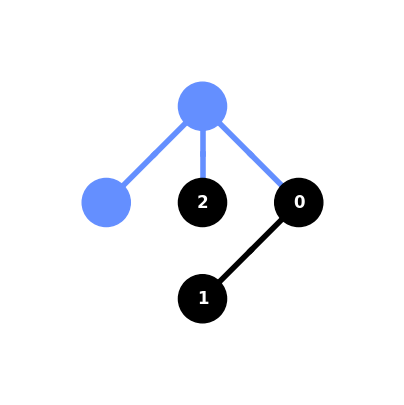

In [13]:
ghz = QuantumCircuit(3, 3)
ghz.h(0)
ghz.cx(0,range(1,3))
ghz.barrier()
ghz.measure(range(3), range(3))

# Virtual -> physical
#    0    ->    3
#    1    ->    4
#    2    ->    2

my_ghz = transpile(ghz, backend, initial_layout=[3, 4, 2])
plot_circuit_layout(my_ghz, backend)

## Routing Stage

Prendiamo il seguente circuito **GHZ** ed eseguiamo il transpile $100$ volte per vedere come varia la profondità dei circuiti ottenuti:

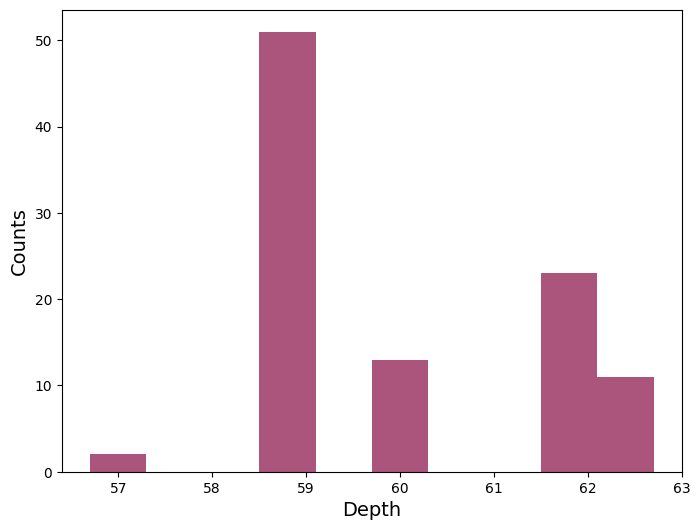

In [14]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.providers.fake_provider import FakeAuckland

backend = FakeAuckland()

ghz = QuantumCircuit(15)
ghz.h(0)
ghz.cx(0, range(1, 15))

#display(ghz.draw('mpl'))

depths = []
for _ in range(100):
    depths.append(
        transpile(
            ghz,
            backend,
            layout_method='trivial'  # Fixed layout mapped in circuit order
        ).depth()
    )

plt.figure(figsize=(8, 6))
plt.hist(depths, align='left', color='#AC557C')
plt.xlabel('Depth', fontsize=14)
plt.ylabel('Counts', fontsize=14);

## Optimization Stage

Vediamo come variano le caratteristiche dei circuiti per i diversi livelli di ottimizzazione:

Depths:  [71, 47, 43, 45]
Number of gates:  [107, 48, 45, 55]
Non-local gates:  [104, 45, 42, 31]


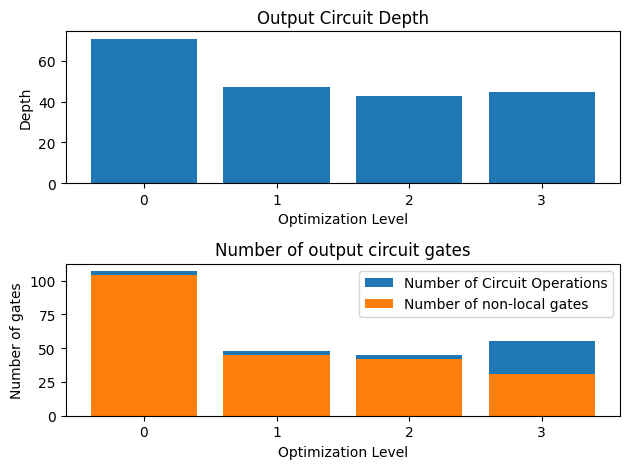

In [18]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.providers.fake_provider import FakeAuckland

backend = FakeAuckland()

ghz = QuantumCircuit(15)
ghz.h(0)
ghz.cx(0, range(1, 15))

depths = []
gate_counts = []
non_local_gate_counts = []
levels = [str(x) for x in range(4)]

for level in range(4):
     circ = transpile(ghz, backend, optimization_level=level)
     depths.append(circ.depth())
     gate_counts.append(sum(circ.count_ops().values()))
     non_local_gate_counts.append(circ.num_nonlocal_gates())

print("Depths: ", depths)
print("Number of gates: ", gate_counts)
print("Non-local gates: ", non_local_gate_counts)

# plot
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.bar(levels, depths, label='Depth')
ax1.set_xlabel("Optimization Level")
ax1.set_ylabel("Depth")
ax1.set_title("Output Circuit Depth")
ax2.bar(levels, gate_counts, label='Number of Circuit Operations')
ax2.bar(levels, non_local_gate_counts, label='Number of non-local gates')
ax2.set_xlabel("Optimization Level")
ax2.set_ylabel("Number of gates")
ax2.legend()
ax2.set_title("Number of output circuit gates")
fig.tight_layout()
plt.show()

## Scheduling Stage

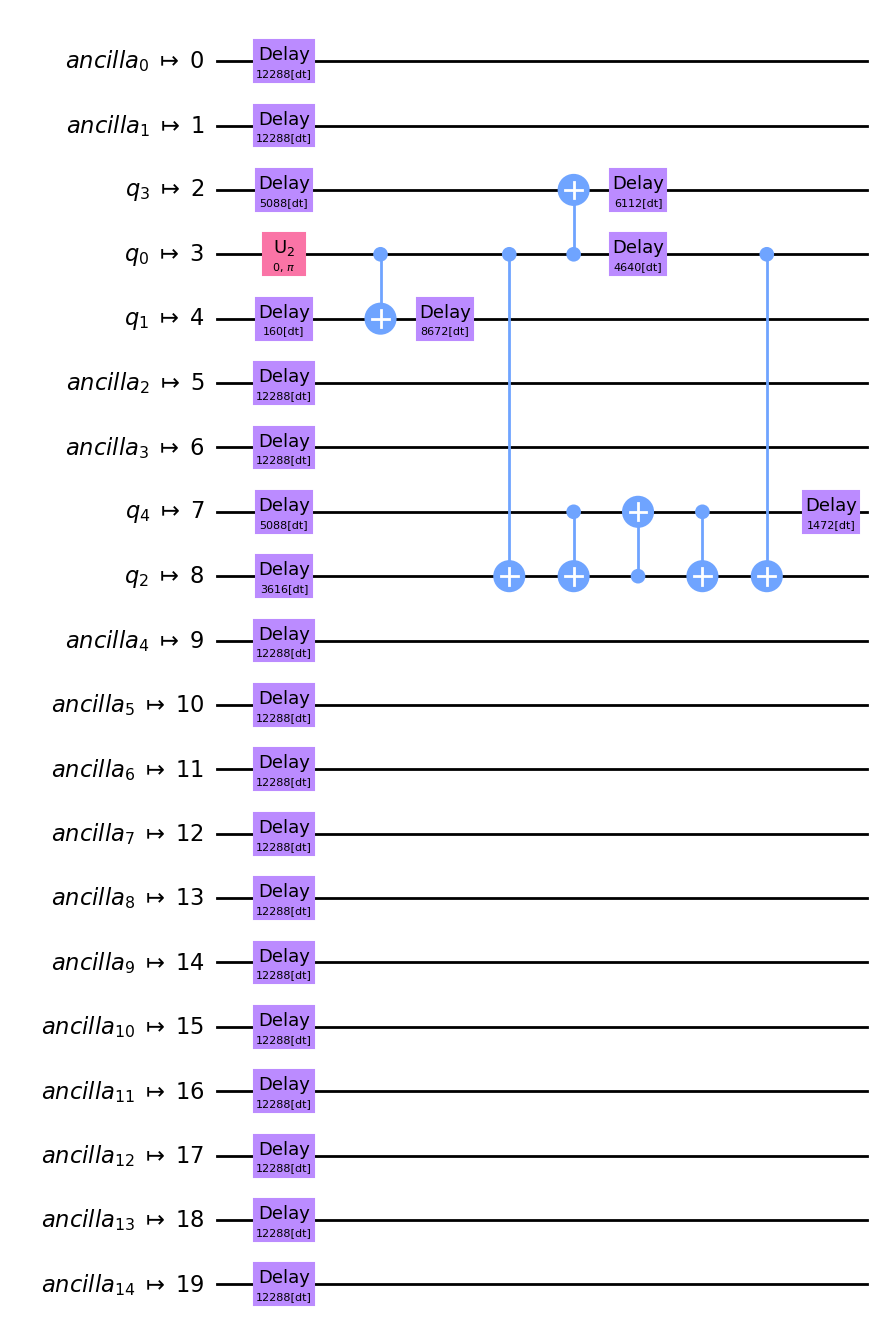

In [26]:
from qiskit import QuantumCircuit, transpile
from qiskit.providers.fake_provider import FakeBoeblingen

backend = FakeBoeblingen()

ghz = QuantumCircuit(5)
ghz.h(0)
ghz.cx(0,range(1,5))
#display(ghz.draw('mpl'))

circ = transpile(ghz, backend, scheduling_method="asap")
circ.draw(output='mpl')

Per vedere meglio il tempo di inattività:

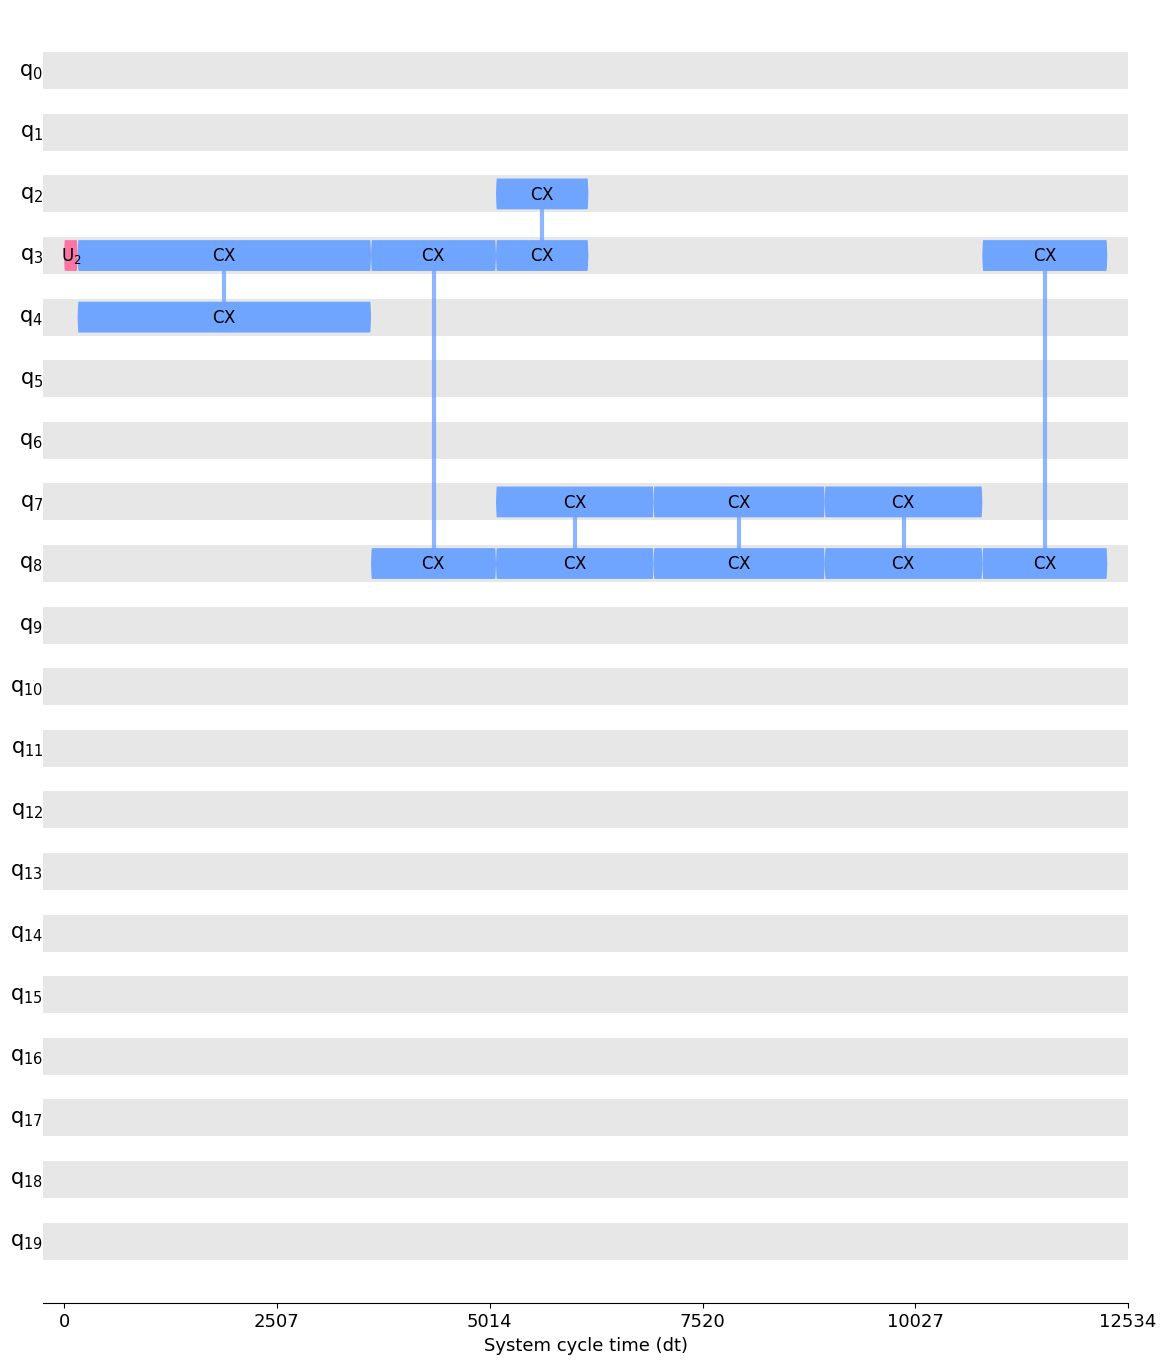

In [27]:
from qiskit.visualization import timeline_drawer

timeline_drawer(circ)